In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## import data

In [2]:
df_o2 = pd.read_csv('../Dissertation_projects/Data/CTD/O2_Summary_Stats.csv', sep=',', index_col=0)

In [3]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [6]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [7]:
#get BC data sets 
df_iron_bc = df_iron[df_iron['Type'] == 'BC']

#get PW data sets 
df_iron_pw = df_iron[df_iron['Type'] == 'PW']

#get WC data sets 
df_iron_wc = df_iron[df_iron['Type'] == 'WC']

#get RHZ data 
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]

## Data for flux calculations 

In [8]:
#hights data
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [9]:
#porosity data 
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [10]:
#location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')

## slope calculations

In [11]:
#figure calculate pore water 

#Fe2 and Fe3 slopes
df_iron_pw = df_iron_pw[(df_iron_pw['Fe2_uM'] != 0)]
#df_iron_pw = df_iron_pw[(df_iron_pw['Fe2_Depth'] > 0)]
df_iron_pw = df_iron_pw.dropna(subset=["Fe2_uM"])
df_iron_pw = df_iron_pw.sort_values(by='code')
codes = df_iron_pw['code'].unique()

print(codes)
len(codes)

['St.11_GOM2021' 'St.11_GOM21FA' 'St.11_GOM22SU' 'St.12_GOM21FA'
 'St.12_GOM22SU' 'St.13_GOM21FA' 'St.13_GOM22SP' 'St.13_GOM22SU'
 'St.14_GOM2021' 'St.14_GOM21FA' 'St.14_GOM22SP' 'St.14_GOM22SU'
 'St.15_GOM2021' 'St.15_GOM21FA' 'St.15_GOM22SP' 'St.15_GOM22SU'
 'St.16_GOM2021' 'St.16_GOM21FA' 'St.16_GOM22SP' 'St.16_GOM22SU'
 'St.2_GOM2021' 'St.2_GOM21FA' 'St.2_GOM22SP' 'St.2_GOM22SU'
 'St.4_GOM2021' 'St.4_GOM21FA' 'St.4_GOM22SP' 'St.4_GOM22SU'
 'St.5B_GOM2021' 'St.5B_GOM21FA' 'St.5B_GOM22SP' 'St.5B_GOM22SU'
 'St.7_GOM2021' 'St.7_GOM21FA' 'St.7_GOM22SP' 'St.7_GOM22SU'
 'St.9_GOM2021' 'St.9_GOM21FA' 'St.9_GOM22SP' 'St.9_GOM22SU'
 'St.MK_GOM2021' 'St.MK_GOM21FA' 'St.MK_GOM22SP' 'St.MK_GOM22SU']


44

In [12]:
#df_iron_wc_plot = df_iron_pw[df_iron_pw['code'].isin(codes)]

#max_depth_per_code = df_iron_wc_plot.groupby('code')['Fe2_Depth'].max().reset_index()
#df_iron_wc_plot = pd.merge(df_iron_wc_plot, max_depth_per_code, on='code', suffixes=('', '_max'))
#df_iron_wc_plot = df_iron_wc_plot[df_iron_wc_plot['Fe2_Depth'] == df_iron_wc_plot['Fe2_Depth_max']]
#df_iron_wc_plot.drop(columns=['Fe2_Depth_max'], inplace=True)

#df_iron_wc_plot['Depth_sample'] = df_iron_wc_plot['Fe2_Depth']
#df_iron_wc_plot['Fe2_Depth'] = -0.5
#df_iron_wc_plot

In [13]:
#df_concatenated = pd.concat([df_iron_pw, df_iron_wc_plot], ignore_index=True)
#df_iron_pw = df_iron_wc_plot.sort_values(by='code')
df_iron_pw

Treatment Campaign Location Type   FeT_Date      FeT_uM  \
Sample_ID                                                           
212814          P2F  GOM2021    St.11   PW  7/25/2021   65.282000   
212822          P2F  GOM2021    St.11   PW  7/25/2021  268.630000   
212821          P2F  GOM2021    St.11   PW  7/25/2021  151.221000   
212820          P2F  GOM2021    St.11   PW  7/25/2021  140.656000   
212819          P2F  GOM2021    St.11   PW  7/25/2021  102.654000   
...             ...      ...      ...  ...        ...         ...   
225301          P2F  GOM22SU    St.MK   PW  7/23/2022   19.695043   
225300          P2F  GOM22SU    St.MK   PW  7/23/2022    0.000000   
225321          P2F  GOM22SU    St.MK   PW        NaN         NaN   
225310          P2F  GOM22SU    St.MK   PW  7/23/2022   16.426929   
225305          P2F  GOM22SU    St.MK   PW  7/23/2022  114.978738   

                FeT_mgL FeT_Notes  FeT_Depth  FeT_Time   Fe2_Date  Fe2_uM  \
Sample_ID                                                                   
212814              NaN  St.11 14      12.95       NaN  7/25/2021   1.163   
212822              NaN  St.11 22      30.70       NaN  7/25/2021  54.518   
212821              NaN  St.11 21      27.70       NaN  7/25/2021  21.807   
212820              NaN  St.11 20      24.70       NaN  7/25/2021  24.424   
212819              NaN  St.11 19      22.20       NaN  7/25/2021  16.719   
...                 ...       ...        ...       ...        ...     ...   
225301      1.099869666       NaN       0.35       NaN  7/24/2022   1.336   
225300     -0.017267357       NaN      -0.02       NaN  7/24/2022   0.403   
225321              NaN       NaN      27.70       NaN  7/24/2022   1.032   
225310      0.917361851       NaN       7.70       NaN  7/24/2022   0.647   
225305       6.42098762       NaN       3.15       NaN  7/24/2022   1.689   

          Fe2_mgL              Fe2_Notes  Fe2_Depth  Fe2_Time      Fe3_uM  \
Sample_ID                                                                   
212814        NaN               St.11 14      12.95       NaN   64.119000   
212822        NaN               St.11 22      30.70       NaN  214.112000   
212821        NaN               St.11 21      27.70       NaN  129.414000   
212820        NaN               St.11 20      24.70       NaN  116.232000   
212819        NaN               St.11 19      22.20       NaN   85.935000   
...           ...                    ...        ...       ...         ...   
225301      0.075  Left out og glove bag       0.35       NaN   18.359043   
225300      0.022  Left out og glove bag      -0.02       NaN    0.000000   
225321      0.058  Left out og glove bag      27.70       NaN         NaN   
225310      0.036  Left out og glove bag       7.70       NaN   15.779929   
225305      0.094  Left out og glove bag       3.15       NaN  113.289738   

                    code  
Sample_ID                 
212814     St.11_GOM2021  
212822     St.11_GOM2021  
212821     St.11_GOM2021  
212820     St.11_GOM2021  
212819     St.11_GOM2021  
...                  ...  
225301     St.MK_GOM22SU  
225300     St.MK_GOM22SU  
225321     St.MK_GOM22SU  
225310     St.MK_GOM22SU  
225305     St.MK_GOM22SU  

[873 rows x 18 columns]

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\2680493708.py:9: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\2680493708.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel()


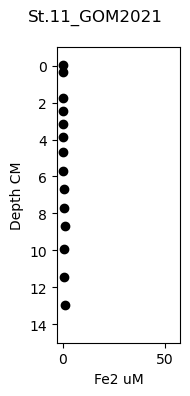

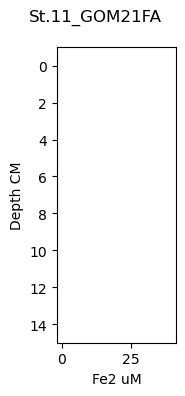

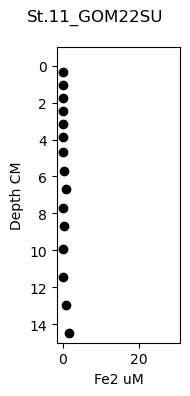

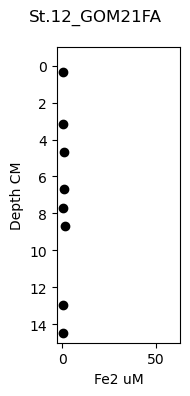

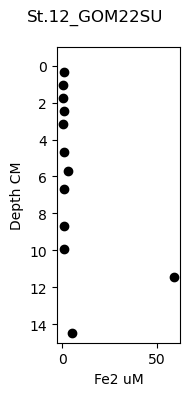

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\2680493708.py:24: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel()/ 1000
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\2680493708.py:25: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\2680493708.py:33: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel()


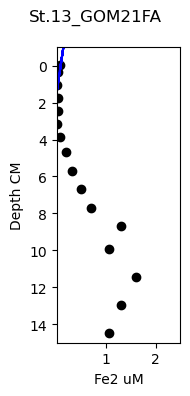

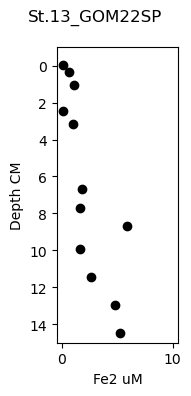

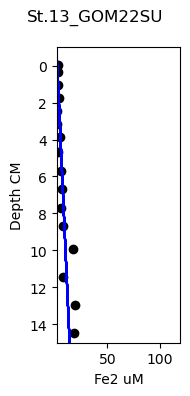

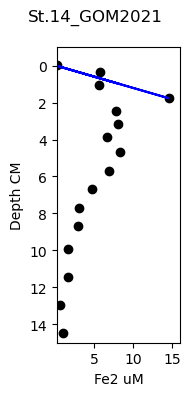

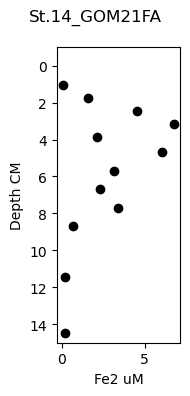

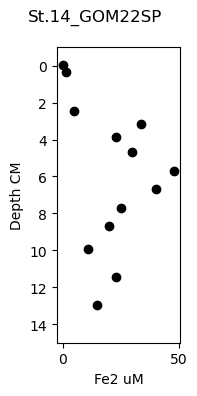

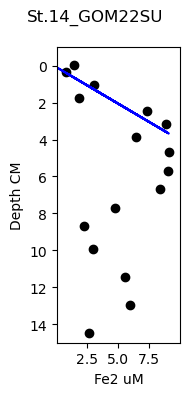

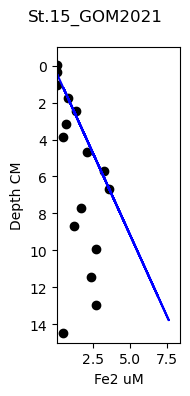

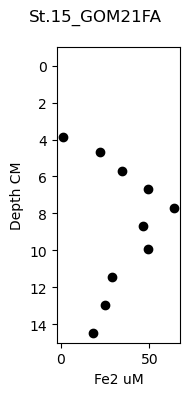

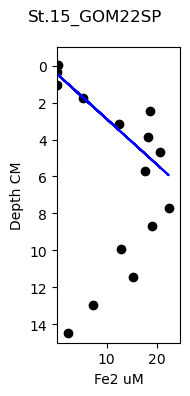

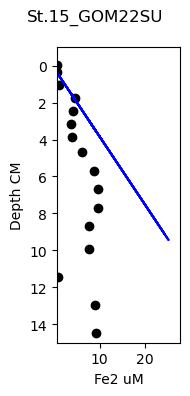

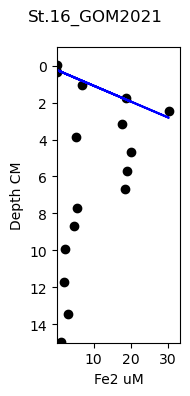

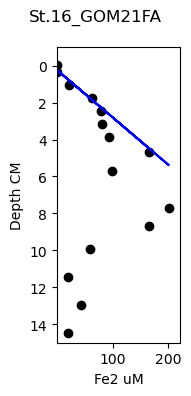

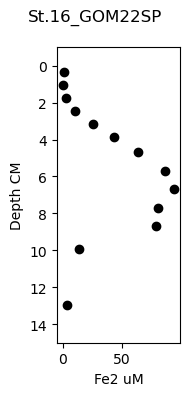

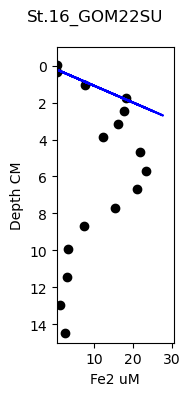

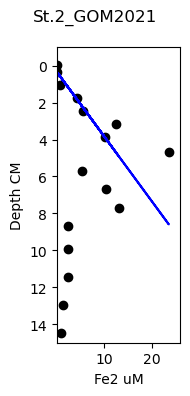

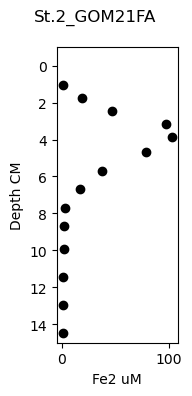

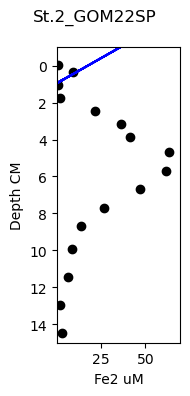

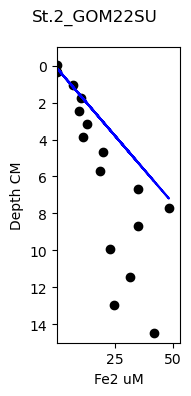

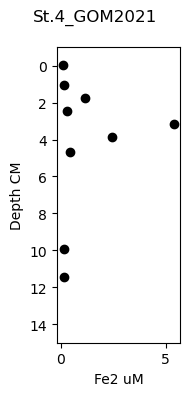

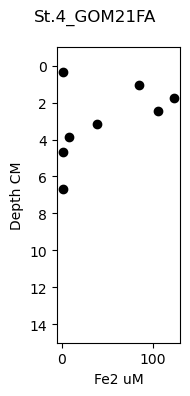

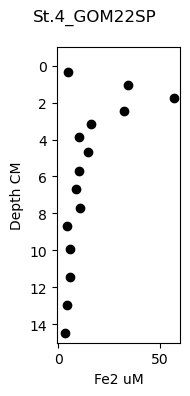

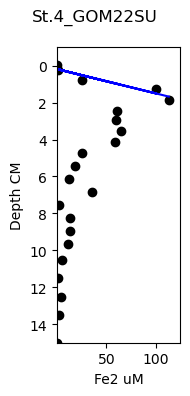

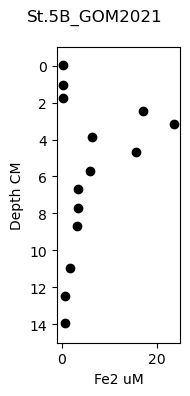

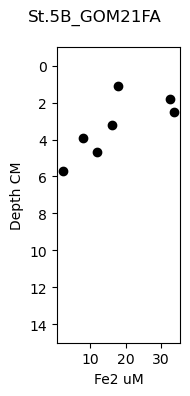

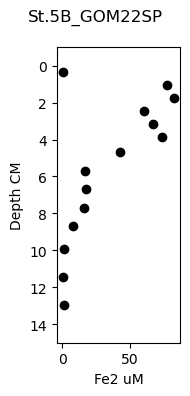

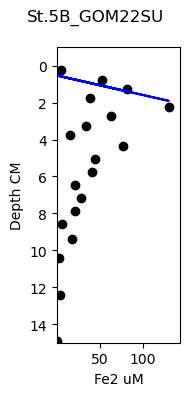

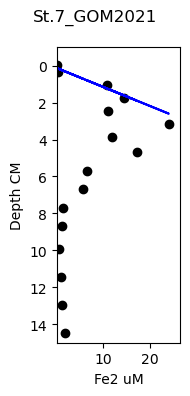

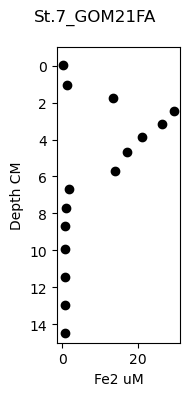

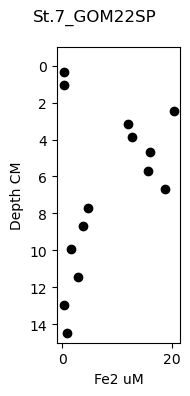

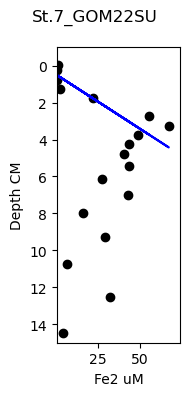

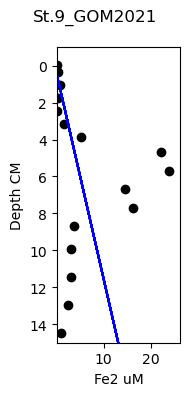

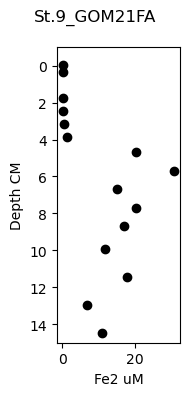

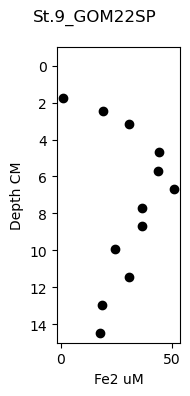

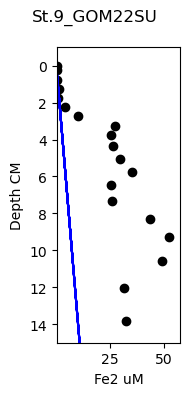

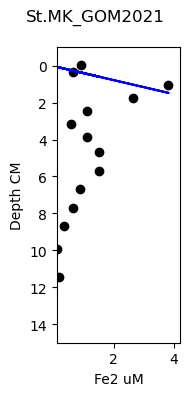

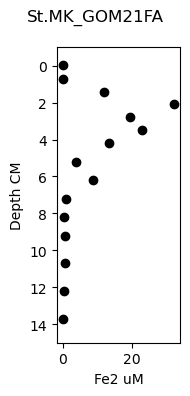

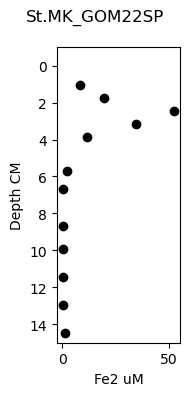

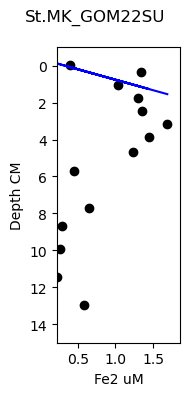

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\2680493708.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  slopes_fe2_pw['por_mean'].fillna(0.85, inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\2680493708.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


slope_fe2_pw  rsquared_fe2_pw  std_err_fe2_pw  \
code                                                           
St.13_GOM21FA    -17.312739         0.316592       17.986253   
St.13_GOM22SU    397.609692         0.503892      278.972656   
St.14_GOM2021   7034.474554         0.858969     2015.510275   
St.14_GOM22SU    557.870477         0.222081      738.294110   
St.15_GOM2021    370.758834         0.652878      191.161842   
St.15_GOM22SP   2671.441459         0.663501     1345.246670   
St.15_GOM22SU   2111.806056         0.772616      810.097544   
St.16_GOM2021  10766.357567         0.923732     2187.512393   
St.16_GOM21FA  35920.800305         0.921419     7417.565324   
St.16_GOM22SU  10356.436021         0.937694     1887.686748   
St.2_GOM2021    2285.886576         0.800348      807.304100   
St.2_GOM22SP   -1520.011015         0.083815     3553.552580   
St.2_GOM22SU    6501.679198         0.954199     1007.229576   
St.4_GOM22SU   69089.938276         0.913406    12281.911460   
St.5B_GOM22SU  25584.000000         0.271829    29608.872859   
St.7_GOM2021    9157.016602         0.938160     1662.403901   
St.7_GOM22SU    9826.162742         0.575399     4873.370826   
St.9_GOM2021      94.710865         0.105522      194.983495   
St.9_GOM22SU     281.163415         0.386231      204.633862   
St.MK_GOM2021   1398.621290         0.531382      928.733249   
St.MK_GOM22SU    344.770011         0.390817      304.369847   

               flux_fe2_depth_pw  por_mean    por_sd  por_count    por_SE  \
code                                                                        
St.13_GOM21FA                2.0  0.908008  0.004741        4.0  0.002371   
St.13_GOM22SU                2.0  0.879924  0.020249        2.0  0.014318   
St.14_GOM2021                2.0  0.849480  0.020559        4.0  0.010279   
St.14_GOM22SU                2.0  0.873696  0.018698        4.0  0.009349   
St.15_GOM2021                2.0  0.913782  0.023736        4.0  0.011868   
St.15_GOM22SP                2.0  0.910457  0.010509        4.0  0.005255   
St.15_GOM22SU                2.0  0.918533  0.012584        4.0  0.006292   
St.16_GOM2021                2.0  0.884978  0.004250        4.0  0.002125   
St.16_GOM21FA                2.0  0.851314  0.023436        4.0  0.011718   
St.16_GOM22SU                2.0  0.863702  0.015762        4.0  0.007881   
St.2_GOM2021                 2.0  0.900253  0.019244        4.0  0.009622   
St.2_GOM22SP                 2.0  0.884867  0.013240        4.0  0.006620   
St.2_GOM22SU                 2.0  0.875450  0.011862        4.0  0.005931   
St.4_GOM22SU                 2.0  0.762269  0.034876        4.0  0.017438   
St.5B_GOM22SU                2.0  0.672868  0.050684        4.0  0.025342   
St.7_GOM2021                 2.0  0.905406  0.012433        4.0  0.006217   
St.7_GOM22SU                 2.0  0.877682  0.015555        4.0  0.007777   
St.9_GOM2021                 2.0  0.861734  0.010412        4.0  0.005206   
St.9_GOM22SU                 2.0  0.872078  0.007654        4.0  0.003827   
St.MK_GOM2021                2.0  0.524421  0.078036        4.0  0.039018   
St.MK_GOM22SU                2.0  0.808071  0.010697        4.0  0.005348   

               pw_flux_fe2  pw_flux_fe2_error        Lat        Lon    Stn  \
code                                                                         
St.13_GOM21FA    -0.000960           0.000998  28.524193 -89.610854  St.13   
St.13_GOM22SU     0.021372           0.014995  28.524547 -89.597871  St.13   
St.14_GOM2021     0.365021           0.104585  28.726863 -89.601437  St.14   
St.14_GOM22SU     0.029773           0.039402  28.728776 -89.620647  St.14   
St.15_GOM2021     0.020695           0.010670  28.942528 -88.835023  St.15   
St.15_GOM22SP     0.148572           0.074816  28.944296 -88.860281  St.15   
St.15_GOM22SU     0.118490           0.045453  28.950645 -88.842176  St.15   
St.16_GOM2021     0.582015           0.118254  28.876302 -89.547035 

In [14]:
Frames = []

def fe2_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_iron_pw.loc[df_iron_pw['code'] == codes[code]]
    y = sub['Fe2_Depth']
    x = sub['Fe2_uM']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel() 
    xx = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel()
    
    axs.set_xlabel('Fe2 uM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-1)

    if len(xx) > 3:
        # Add subplot labels
        axs.set_xlim(sub['Fe2_uM'].min(),sub['Fe2_uM'].max()*1.1)
    
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='b')        
        
        xx2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel()/ 1000
        yy2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err

        df_p = df_por.loc[df_por['code'] == codes[code]]
        df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
        por_mean = df_por_data.mean()
        por_std = df_por_data.std()
        por_count = len(df_por_data)

    else:
        slope = np.nan
        rsquared = np.nan
        std_err = np.nan

        df_p = np.nan
        df_por_data = np.nan
        por_mean = np.nan
        por_std = np.nan
        por_count = np.nan
    
    dic = {'code':[codes[code]],
           'slope_fe2_pw':[slope],
           'rsquared_fe2_pw':[rsquared], 
           'std_err_fe2_pw':[std_err], 
           'flux_fe2_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()

dep = 2

fe2_flux_cal(0, dep, -1)
fe2_flux_cal(1, dep, -1)
fe2_flux_cal(2, dep, -1)
fe2_flux_cal(3, dep, -1)
fe2_flux_cal(4, dep, -1)
fe2_flux_cal(5, dep, -1)
fe2_flux_cal(6, dep, -1)
fe2_flux_cal(7, dep, -1)
fe2_flux_cal(8, dep, -1)
fe2_flux_cal(9, dep, -1)
fe2_flux_cal(10, dep, -1)
fe2_flux_cal(11, dep, -1)
fe2_flux_cal(12, dep, -1)
fe2_flux_cal(13, dep, -1)
fe2_flux_cal(14, dep, -1)
fe2_flux_cal(15, dep, -1)
fe2_flux_cal(16, dep, -1)
fe2_flux_cal(17, dep, -1)
fe2_flux_cal(18, dep, -1)
fe2_flux_cal(19, dep, -1)
fe2_flux_cal(20, dep, -1)
fe2_flux_cal(21, dep, -1)
fe2_flux_cal(22, dep, -1)
fe2_flux_cal(23, dep, -1)
fe2_flux_cal(24, dep, -1)
fe2_flux_cal(25, dep, -1)
fe2_flux_cal(26, dep, -1)
fe2_flux_cal(27, dep, -1)
fe2_flux_cal(28, dep, -1)
fe2_flux_cal(29, dep, -1)
fe2_flux_cal(30, dep, -1)
fe2_flux_cal(31, dep, -1)
fe2_flux_cal(32, dep, -1)
fe2_flux_cal(33, dep, -1)
fe2_flux_cal(34, dep, -1)
fe2_flux_cal(35, dep, -1)
fe2_flux_cal(36, dep, -1)
fe2_flux_cal(37, dep, -1)
fe2_flux_cal(38, dep, -1)
fe2_flux_cal(39, dep, -1)
fe2_flux_cal(40, dep, -1)
fe2_flux_cal(41, dep, -1)
fe2_flux_cal(42, dep, -1)
fe2_flux_cal(43, dep, -1)


slopes_fe2_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_fe2_pw['por_mean'].fillna(0.85, inplace=True)
slopes_fe2_pw['por_sd'].fillna(0, inplace=True)
slopes_fe2_pw['por_SE'] = slopes_fe2_pw['por_sd'] / (np.sqrt(slopes_fe2_pw['por_count']))
slopes_fe2_pw['por_SE'].fillna(0, inplace=True)

D_fe = 7.07e-06 / 10000 * (86400)

slopes_fe2_pw["pw_flux_fe2"] = slopes_fe2_pw["slope_fe2_pw"] * slopes_fe2_pw["por_mean"] * D_fe 
slopes_fe2_pw["pw_flux_fe2_error"] = slopes_fe2_pw["std_err_fe2_pw"] * slopes_fe2_pw["por_mean"] * D_fe 

slopes_fe2_pw = pd.concat([slopes_fe2_pw, df_lat_lon], axis=1, join='outer')
slopes_fe2_pw['Stn'] = slopes_fe2_pw.index.str.split('_').str[0]
slopes_fe2_pw['Camp'] = slopes_fe2_pw.index.str.split('_').str[1]
slopes_fe2_pw = slopes_fe2_pw.dropna(subset=['pw_flux_fe2'])

slopes_fe2_pw 

In [15]:
#figure calculate pore water 

#Fe2 and Fe3 slopes
df_iron_pw = df_iron_pw[(df_iron_pw['Fe3_uM'] != 0)]
df_iron_pw = df_iron_pw[(df_iron_pw['FeT_Depth'] > 0)]
df_iron_pw = df_iron_pw.dropna(subset=["Fe3_uM"])
df_iron_pw = df_iron_pw.sort_values(by='code')
codes = df_iron_pw['code'].unique()

print(codes)
len(codes)

['St.11_GOM2021' 'St.11_GOM21FA' 'St.11_GOM22SU' 'St.12_GOM21FA'
 'St.12_GOM22SU' 'St.13_GOM21FA' 'St.13_GOM22SP' 'St.13_GOM22SU'
 'St.14_GOM2021' 'St.14_GOM21FA' 'St.14_GOM22SP' 'St.14_GOM22SU'
 'St.15_GOM2021' 'St.15_GOM21FA' 'St.15_GOM22SP' 'St.15_GOM22SU'
 'St.16_GOM2021' 'St.16_GOM21FA' 'St.16_GOM22SP' 'St.16_GOM22SU'
 'St.2_GOM2021' 'St.2_GOM21FA' 'St.2_GOM22SP' 'St.2_GOM22SU'
 'St.4_GOM2021' 'St.4_GOM21FA' 'St.4_GOM22SP' 'St.4_GOM22SU'
 'St.5B_GOM2021' 'St.5B_GOM21FA' 'St.5B_GOM22SP' 'St.5B_GOM22SU'
 'St.7_GOM2021' 'St.7_GOM21FA' 'St.7_GOM22SP' 'St.7_GOM22SU'
 'St.9_GOM2021' 'St.9_GOM21FA' 'St.9_GOM22SP' 'St.9_GOM22SU'
 'St.MK_GOM2021' 'St.MK_GOM21FA' 'St.MK_GOM22SP' 'St.MK_GOM22SU']


44

In [16]:
df_iron_wc_plot = df_iron_wc[df_iron_wc['code'].isin(codes)]

max_depth_per_code = df_iron_wc_plot.groupby('code')['FeT_Depth'].max().reset_index()
df_iron_wc_plot = pd.merge(df_iron_wc_plot, max_depth_per_code, on='code', suffixes=('', '_max'))
df_iron_wc_plot = df_iron_wc_plot[df_iron_wc_plot['FeT_Depth'] == df_iron_wc_plot['FeT_Depth_max']]
df_iron_wc_plot.drop(columns=['FeT_Depth_max'], inplace=True)

df_iron_wc_plot['Depth_sample'] = df_iron_wc_plot['FeT_Depth']
df_iron_wc_plot['FeT_Depth'] = -0.5
df_iron_wc_plot

Treatment Campaign Location Type    FeT_Date    FeT_uM      FeT_mgL  \
0        P2F  GOM21FA    St.5B   WC         NaN       NaN          NaN   
1        P2F  GOM21FA     St.7   WC  10/31/2021       NaN          BDL   
3        P2F  GOM21FA    St.14   WC         NaN       NaN          NaN   
5        P2F  GOM21FA     St.9   WC   11/1/2021  0.098651  0.005509188   
6        P2F  GOM21FA     St.9   WC   11/1/2021  0.012271   0.00068525   
7        P2F  GOM21FA    St.15   WC   11/2/2021  0.018579  0.001037525   
8        P2F  GOM21FA    St.15   WC   11/2/2021  0.020420  0.001140366   
12       P2F  GOM21FA    St.16   WC   11/8/2021  0.003652  0.000203973   
13       P2F  GOM21FA    St.16   WC         NaN       NaN          NaN   
14       P2F  GOM21FA    St.12   WC   11/9/2021  0.000000            0   
15       P2F  GOM21FA    St.12   WC   11/9/2021  0.034672  0.001936252   
16       P2F  GOM21FA    St.11   WC  11/10/2021  0.015236  0.000850848   
17       P2F  GOM21FA    St.11   WC  11/10/2021  0.016706  0.000932967   
19       P2F  GOM22SP     St.7   WC   4/10/2022  0.003726  0.000208056   
20       P2F  GOM22SP    St.14   WC    4/9/2022  0.018545  0.001035656   
22       P2F  GOM22SP    St.16   WC         NaN       NaN          NaN   
23       P2F  GOM22SP    St.16   WC         NaN       NaN          NaN   
28       P2F  GOM22SP    St.5B   WC   4/14/2022  0.013865  0.000774273   
30       P2F  GOM22SP    St.15   WC   4/16/2022  0.010790  0.000602574   
33       P2F  GOM22SP     St.9   WC   4/16/2022  0.004285  0.000239318   
35       P2F  GOM22SP     St.2   WC   4/17/2022  0.007521  0.000419987   
37       P2F  GOM22SP    St.13   WC         NaN       NaN          NaN   
41       P2F  GOM22SP     St.4   WC         NaN       NaN          NaN   
44       P2F  GOM22SU     St.4   WC   7/10/2022  0.029000      0.00162   
45       P2F  GOM22SU     St.4   WC   7/10/2022  0.034200      0.00191   
47       P2F  GOM22SU    St.5B   WC   7/10/2022  0.022200      0.00124   
48       P2F  GOM22SU    St.5B   WC   7/10/2022  0.039800      0.00222   
50       P2F  GOM22SU    St.14   WC   7/16/2022  0.013600      0.00076   
51       P2F  GOM22SU    St.14   WC   7/16/2022  0.012200      0.00068   
53       P2F  GOM22SU     St.7   WC   7/12/2022  0.012700      0.00071   
54       P2F  GOM22SU     St.7   WC   7/12/2022  0.062300      0.00348   
56       P2F  GOM22SU     St.9   WC   7/17/2022  0.023800      0.00133   
57       P2F  GOM22SU     St.9   WC   7/17/2022  0.017400      0.00097   
59       P2F  GOM22SU    St.15   WC   7/15/2022  0.020800      0.00116   
62       P2F  GOM22SU    St.13   WC   7/18/2022  0.015900      0.00089   
63       P2F  GOM22SU    St.13   WC   7/18/2022  0.000000     -0.00051   
65       P2F  GOM22SU     St.2   WC   7/19/2022  0.034800      0.00194   
66       P2F  GOM22SU     St.2   WC   7/19/2022  0.016400      0.00092   
67       P2F  GOM22SU     St.2   WC   7/19/2022  0.072800      0.00407   
68       P2F  GOM22SU    St.12   WC   7/21/2022  0.029100      0.00162   
69       P2F  GOM22SU    St.12   WC   7/21/2022  0.020400      0.00114   
71       P2F  GOM22SU    St.16   WC   7/20/2022  0.018000      0.00101   
72       P2F  GOM22SU    St.16   WC   7/20/2022  0.024100      0.00135   
74       P2F  GOM22SU    St.11   WC   7/22/2022  0.019600      0.00109   
77       P2F  GOM22SU    St.MK   WC   7/23/2022  0.040500      0.00226   
78       P2F  GOM22SU    St.MK   WC   7/23/2022  0.037400      0.00209   
79       P2F  GOM22SU    St.MK   WC   7/23/2022  0.036000      0.00201   

   FeT_Notes  FeT_Depth  FeT_Time    Fe2_Date    Fe2_uM      Fe2_mgL  \
0        NaN       -0.5       NaN  10/25/2021  0.008333  0.000465365   
1        NaN       -0.5       NaN  10/31/2021  0.002868  0.000160152   
3        NaN       -0.5       NaN  10/31/2021       NaN          BDL   
5        NaN       -0.5       NaN   11/1/2021  0.011973  0.000668651   
6        NaN       -0.5       NaN   11/1/2021  0.011376  0.000635298   
7        NaN      

In [17]:
df_concatenated = pd.concat([df_iron_pw, df_iron_wc_plot], ignore_index=True)
df_iron_pw = df_concatenated.sort_values(by='code')
df_iron_pw

Treatment Campaign Location Type   FeT_Date      FeT_uM      FeT_mgL  \
0         P2F  GOM2021    St.11   PW  7/25/2021   65.282000          NaN   
15        P2F  GOM2021    St.11   PW  7/25/2021  268.630000          NaN   
14        P2F  GOM2021    St.11   PW  7/25/2021  151.221000          NaN   
13        P2F  GOM2021    St.11   PW  7/25/2021  140.656000          NaN   
12        P2F  GOM2021    St.11   PW  7/25/2021  102.654000          NaN   
..        ...      ...      ...  ...        ...         ...          ...   
759       P2F  GOM22SU    St.MK   PW  7/23/2022    9.463629  0.528496371   
760       P2F  GOM22SU    St.MK   PW  7/23/2022   16.426929  0.917361851   
808       P2F  GOM22SU    St.MK   WC  7/23/2022    0.037400      0.00209   
762       P2F  GOM22SU    St.MK   PW  7/23/2022  114.978738   6.42098762   
809       P2F  GOM22SU    St.MK   WC  7/23/2022    0.036000      0.00201   

    FeT_Notes  FeT_Depth  FeT_Time   Fe2_Date  Fe2_uM   Fe2_mgL  \
0    St.11 14      12.95       NaN  7/25/2021   1.163       NaN   
15   St.11 22      30.70       NaN  7/25/2021  54.518       NaN   
14   St.11 21      27.70       NaN  7/25/2021  21.807       NaN   
13   St.11 20      24.70       NaN  7/25/2021  24.424       NaN   
12   St.11 19      22.20       NaN  7/25/2021  16.719       NaN   
..        ...        ...       ...        ...     ...       ...   
759       NaN      24.70       NaN  7/24/2022   0.677     0.038   
760       NaN       7.70       NaN  7/24/2022   0.647     0.036   
808       NaN      -0.50       NaN  7/24/2022   0.000  -0.00054   
762       NaN       3.15       NaN  7/24/2022   1.689     0.094   
809       NaN      -0.50       NaN  7/24/2022   0.000  -0.00059   

                 Fe2_Notes  Fe2_Depth  Fe2_Time      Fe3_uM           code  \
0                 St.11 14      12.95       NaN   64.119000  St.11_GOM2021   
15                St.11 22      30.70       NaN  214.112000  St.11_GOM2021   
14                St.11 21      27.70       NaN  129.414000  St.11_GOM2021   
13                St.11 20      24.70       NaN  116.232000  St.11_GOM2021   
12                St.11 19      22.20       NaN   85.935000  St.11_GOM2021   
..                     ...        ...       ...         ...            ...   
759  Left out og glove bag      24.70       NaN    8.786629  St.MK_GOM22SU   
760  Left out og glove bag       7.70       NaN   15.779929  St.MK_GOM22SU   
808                    NaN      17.20       NaN    0.037400  St.MK_GOM22SU   
762  Left out og glove bag       3.15       NaN  113.289738  St.MK_GOM22SU   
809                    NaN      17.20       NaN    0.036000  St.MK_GOM22SU   

     Depth_sample  
0             NaN  
15            NaN  
14            NaN  
13            NaN  
12            NaN  
..            ...  
759           NaN  
760           NaN  
808          17.2  
762           NaN  
809          17.2  

[810 rows x 19 columns]

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\892108006.py:9: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\892108006.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel()


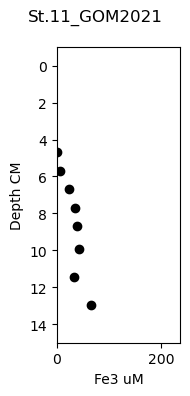

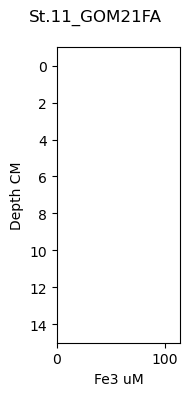

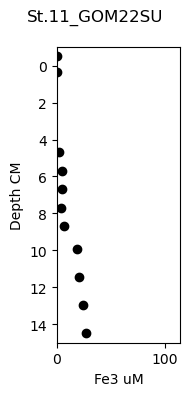

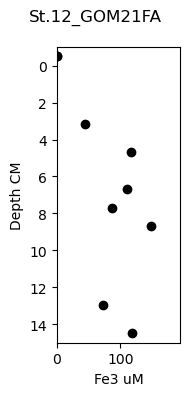

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\892108006.py:23: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel()/ 1000
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\892108006.py:24: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\892108006.py:32: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel()


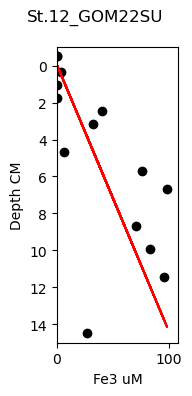

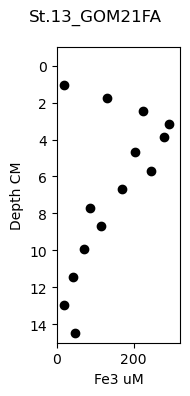

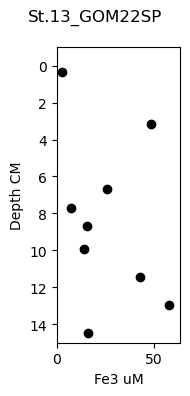

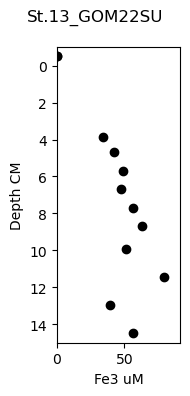

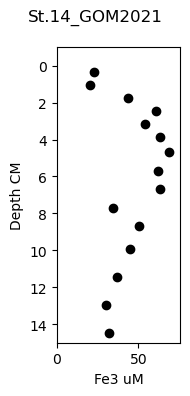

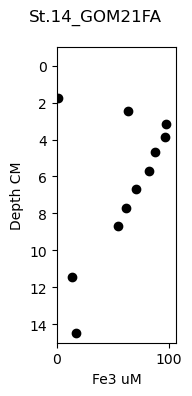

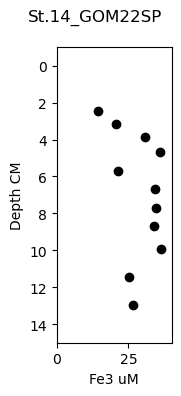

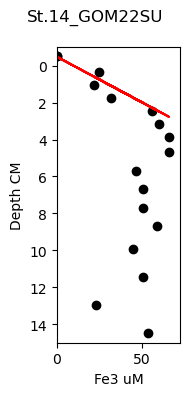

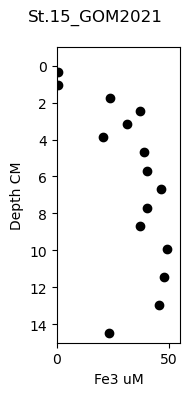

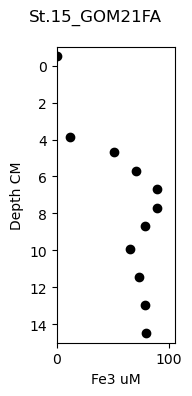

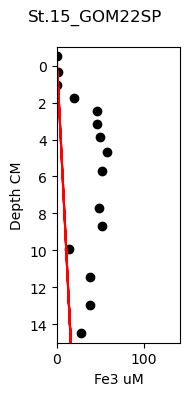

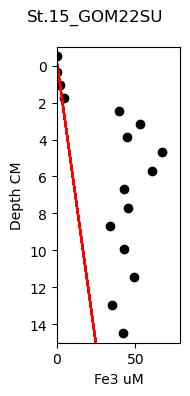

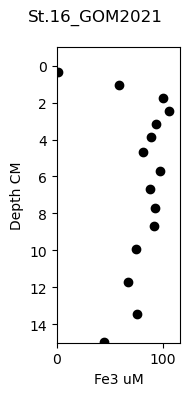

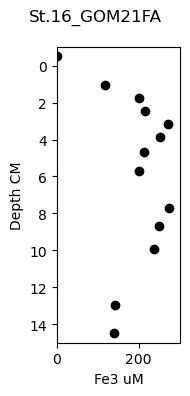

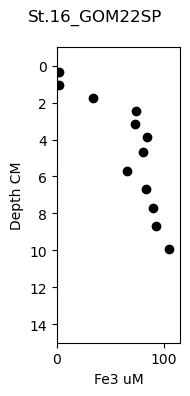

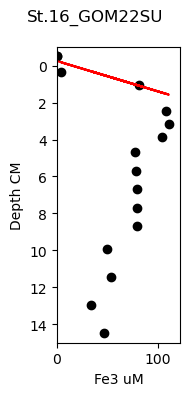

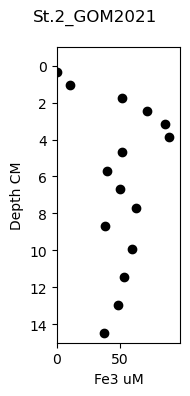

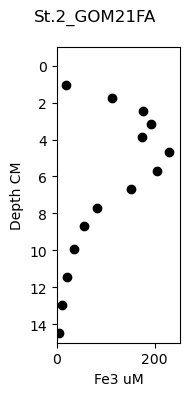

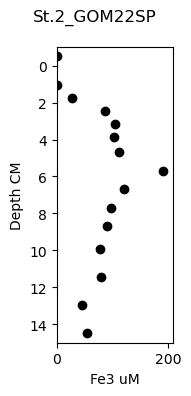

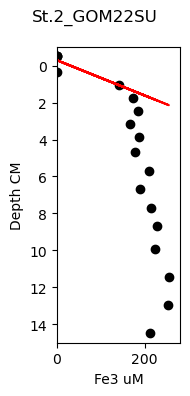

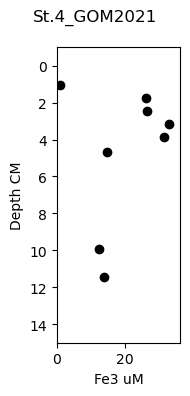

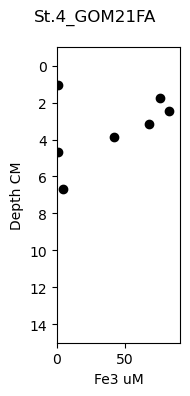

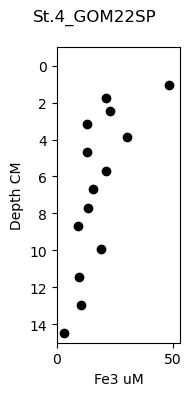

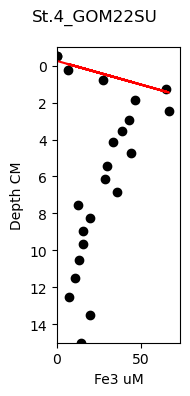

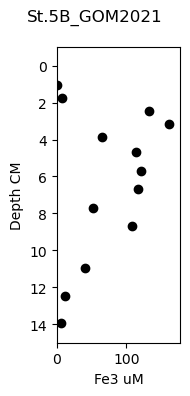

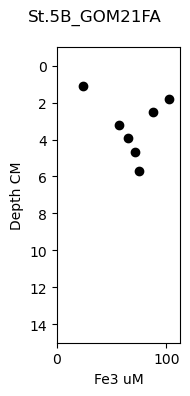

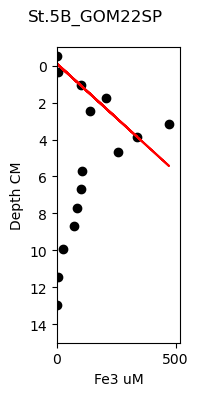

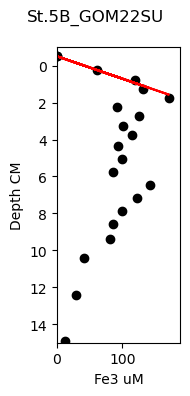

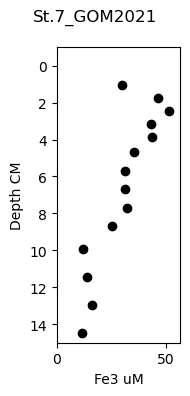

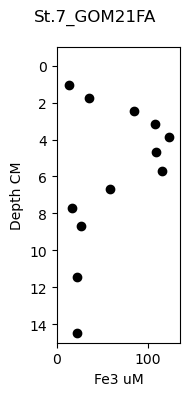

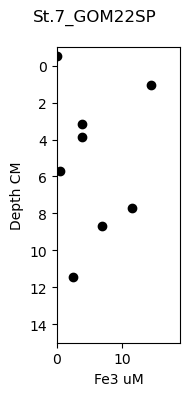

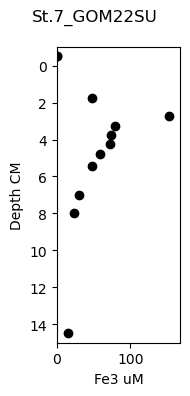

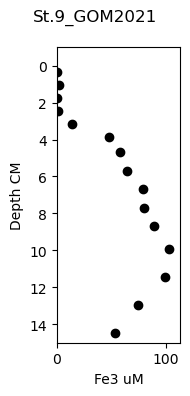

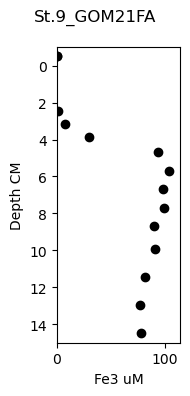

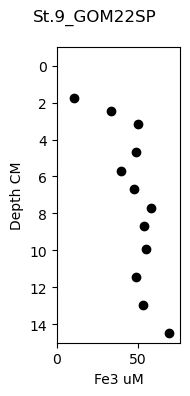

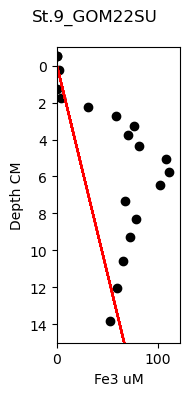

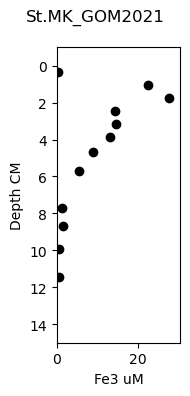

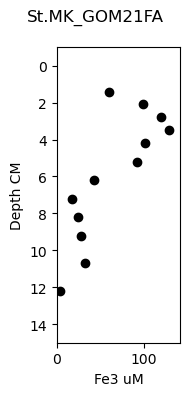

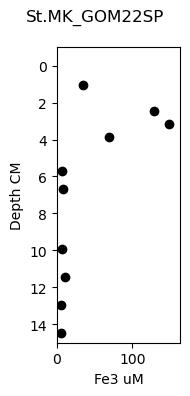

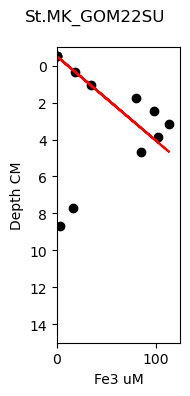

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\892108006.py:118: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  slopes_fe3_pw['por_mean'].fillna(0.85, inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_11804\892108006.py:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

slope_fe3_pw  rsquared_fe3_pw  std_err_fe3_pw  \
code                                                           
St.12_GOM22SU    630.148368         0.091037     1407.963065   
St.14_GOM22SU  16100.949555         0.792541     5824.943845   
St.15_GOM22SP    320.573683         0.306033      482.740322   
St.15_GOM22SU   1251.253112         0.766804      690.022211   
St.16_GOM22SU  46381.477745         0.758947    18483.319059   
St.2_GOM22SU   76878.123163         0.731671    26879.286009   
St.4_GOM22SU   33277.705263         0.848241     8126.621115   
St.5B_GOM22SP  62228.455443         0.728555    37983.860641   
St.5B_GOM22SU  80485.452632         0.974723     7483.031835   
St.9_GOM22SU     239.172817         0.053996      707.884361   
St.MK_GOM22SU  21985.721009         0.999854      153.306784   

               flux_fe3_depth_pw  por_mean    por_sd  por_count    por_SE  \
code                                                                        
St.12_GOM22SU                1.5  0.852023  0.016548        3.0  0.009554   
St.14_GOM22SU                1.5  0.880874  0.016127        3.0  0.009311   
St.15_GOM22SP                1.5  0.913622  0.010354        3.0  0.005978   
St.15_GOM22SU                1.5  0.921826  0.012952        3.0  0.007478   
St.16_GOM22SU                1.5  0.870193  0.012757        3.0  0.007365   
St.2_GOM22SU                 1.5  0.880412  0.009443        3.0  0.005452   
St.4_GOM22SU                 1.5  0.779106  0.022089        3.0  0.012753   
St.5B_GOM22SP                1.5  0.832219  0.033814        3.0  0.019523   
St.5B_GOM22SU                1.5  0.680307  0.056602        3.0  0.032679   
St.9_GOM22SU                 1.5  0.874702  0.007112        3.0  0.004106   
St.MK_GOM22SU                1.5  0.805482  0.011214        3.0  0.006474   

               pw_flux_fe3  pw_flux_fe3_error        Lat        Lon    Stn  \
code                                                                         
St.12_GOM22SU     0.032796           0.073278  28.593063 -88.878258  St.12   
St.14_GOM22SU     0.866360           0.313429  28.728776 -89.620647  St.14   
St.15_GOM22SP     0.017891           0.026941  28.944296 -88.860281  St.15   
St.15_GOM22SU     0.070458           0.038855  28.950645 -88.842176  St.15   
St.16_GOM22SU     2.465433           0.982491  28.891260 -89.536424  St.16   
St.2_GOM22SU      4.134488           1.445562  28.896161 -89.585844   St.2   
St.4_GOM22SU      1.583737           0.386758  28.793151 -90.697399   St.4   
St.5B_GOM22SP     3.163441           1.930945  28.808891 -91.338694  St.5B   
St.5B_GOM22SU     3.344689           0.310968  28.797889 -91.322172  St.5B   
St.9_GOM22SU      0.012779           0.037823  28.786307 -89.598689   St.9   
St.MK_GOM22SU     1.081757           0.007543  28.903147 -90.301611  St.MK   

                  Camp  
code                    
St.12_GOM22SU  GOM22SU  
St.14_GOM22SU  GOM22SU  
St.15_GOM22SP  GOM22SP  
St.15_GOM22SU  GOM22SU  
St.16_GOM22SU  GOM22SU  
St.2_GOM22SU   GOM22SU  
St.4_GOM22SU   GOM22SU  
St.5B_GOM22SP  GOM22SP  
St.5B_GOM22SU  GOM22SU  
St.9_GOM22SU   GOM22SU  
St.MK_GOM22SU  GOM22SU

In [18]:
Frames = []

def fe3_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_iron_pw.loc[df_iron_pw['code'] == codes[code]]
    y = sub['FeT_Depth']
    x = sub['Fe3_uM']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel() 
    xx = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('Fe3 uM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-1)
    axs.set_xlim(df_iron_pw['Fe3_uM'].min(),sub['Fe3_uM'].max()*1.1)
    
    if len(xx) > 2:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='r')        
        
        xx2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel()/ 1000 
        yy2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
    
        df_p = df_por.loc[df_por['code'] == codes[code]]
        df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
        por_mean = df_por_data.mean()
        por_std = df_por_data.std()
        por_count = len(df_por_data)
        
    else:
        slope = np.nan
        rsquared = np.nan
        std_err = np.nan

        df_p = np.nan
        df_por_data = np.nan
        por_mean = np.nan
        por_std = np.nan
        por_count = np.nan

        
    dic = {'code':[codes[code]],
           'slope_fe3_pw':[slope],
           'rsquared_fe3_pw':[rsquared], 
           'std_err_fe3_pw':[std_err], 
           'flux_fe3_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()

dep = 1.5 

fe3_flux_cal(0, dep, -1)
fe3_flux_cal(1, dep, -1)
fe3_flux_cal(2, dep, -1)
fe3_flux_cal(3, dep, -1)
fe3_flux_cal(4, dep, -1)
fe3_flux_cal(5, dep, -1)
fe3_flux_cal(6, dep, -1)
fe3_flux_cal(7, dep, -1)
fe3_flux_cal(8, dep, -1)
fe3_flux_cal(9, dep, -1)
fe3_flux_cal(10, dep, -1)
fe3_flux_cal(11, dep, -1)
fe3_flux_cal(12, dep, -1)
fe3_flux_cal(13, dep, -1)
fe3_flux_cal(14, dep, -1)
fe3_flux_cal(15, dep, -1)
fe3_flux_cal(16, dep, -1)
fe3_flux_cal(17, dep, -1)
fe3_flux_cal(18, dep, -1)
fe3_flux_cal(19, dep, -1)
fe3_flux_cal(20, dep, -1)
fe3_flux_cal(21, dep, -1)
fe3_flux_cal(22, dep, -1)
fe3_flux_cal(23, dep, -1)
fe3_flux_cal(24, dep, -1)
fe3_flux_cal(25, dep, -1)
fe3_flux_cal(26, dep, -1)
fe3_flux_cal(27, dep, -1)
fe3_flux_cal(28, dep, -1)
fe3_flux_cal(29, dep, -1)
fe3_flux_cal(30, dep, -1)
fe3_flux_cal(31, dep, -1)
fe3_flux_cal(32, dep, -1)
fe3_flux_cal(33, dep, -1)
fe3_flux_cal(34, dep, -1)
fe3_flux_cal(35, dep, -1)
fe3_flux_cal(36, dep, -1)
fe3_flux_cal(37, dep, -1)
fe3_flux_cal(38, dep, -1)
fe3_flux_cal(39, dep, -1)
fe3_flux_cal(40, dep, -1)
fe3_flux_cal(41, dep, -1)
fe3_flux_cal(42, dep, -1)
fe3_flux_cal(43, dep, -1)

slopes_fe3_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_fe3_pw['por_mean'].fillna(0.85, inplace=True)
slopes_fe3_pw['por_sd'].fillna(0, inplace=True)
slopes_fe3_pw['por_SE'] = slopes_fe3_pw['por_sd'] / (np.sqrt(slopes_fe3_pw['por_count']))
slopes_fe3_pw['por_SE'].fillna(0, inplace=True)

D_fe = 7.07e-06 / 10000 * (86400)

slopes_fe3_pw["pw_flux_fe3"] = slopes_fe3_pw["slope_fe3_pw"] * slopes_fe3_pw["por_mean"] * D_fe 
slopes_fe3_pw["pw_flux_fe3_error"] = slopes_fe3_pw["std_err_fe3_pw"] * slopes_fe3_pw["por_mean"] * D_fe 
slopes_fe3_pw = pd.concat([slopes_fe3_pw, df_lat_lon], axis=1, join='outer')
slopes_fe3_pw['Stn'] = slopes_fe3_pw.index.str.split('_').str[0]
slopes_fe3_pw['Camp'] = slopes_fe3_pw.index.str.split('_').str[1]
slopes_fe3_pw = slopes_fe3_pw.dropna(subset=['pw_flux_fe3'])

slopes_fe3_pw 

## Benthic Chamber

#figure calculate Benthic chamber 

#Fe2 slops
#df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == 0) | (df_iron_bc['Fe2_uM'].isna())].index)
df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == np.nan) | (df_iron_bc['Fe2_uM'].isna())].index)
codes = df_iron_bc_fe2_cl['code'].unique()

print(codes)
len(codes)

Frames = []

def fe2_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_iron_bc_fe2_cl.loc[df_iron_bc_fe2_cl['code'] == codes[code]]
    x = sub['Fe2_Time']
    y = sub['Fe2_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Fe2_Time'] < time1) & (sub['Fe2_Time'] > time2), 'Fe2_Time'].ravel()
    yy = sub.loc[(sub['Fe2_Time'] < time1) & (sub['Fe2_Time'] > time2), 'Fe2_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='b')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_fe2_bc':[slope],
               'rsquared_fe2_bc':[rsquared], 
               'std_err_fe2_bc':[std_err], 
               'flux_time_fe2_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('Fe2 uM')
    axs.set_xlim(0,df_iron_bc_fe2_cl['Fe2_Time'].max())
    #axs.set_ylim(df_iron_bc_fe2_cl['Fe2_uM'].min(),df_iron_bc_fe2_cl['Fe2_uM'].max())
    axs.set_ylim(0,.2)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe2_flux_cal(0, 6, .5)
fe2_flux_cal(1, 12, 0)
fe2_flux_cal(2, 5, 0)
#fe2_flux_cal(3, 2, 0)
fe2_flux_cal(4, 6, 1)
fe2_flux_cal(5, 7, 1)
fe2_flux_cal(6, 12, 0)
fe2_flux_cal(7, 10, 0)
fe2_flux_cal(8, 12, 0)
fe2_flux_cal(9, 12, 0)
fe2_flux_cal(10, 12, 0)
fe2_flux_cal(11, 12, 0)
fe2_flux_cal(12, 12, 0)
fe2_flux_cal(13, 10, 0)
fe2_flux_cal(14, 10, 0)
fe2_flux_cal(15, 12, 0)
fe2_flux_cal(18, 12, 0)
fe2_flux_cal(19, 8, 0)
fe2_flux_cal(20, 8, 0)
fe2_flux_cal(21, 3, 0)
fe2_flux_cal(22, 8, 0)
fe2_flux_cal(23, 8, 0)
fe2_flux_cal(24, 8, 0)
fe2_flux_cal(25, 11, 0)
fe2_flux_cal(26, 12, 0)
fe2_flux_cal(27, 8, 0)
fe2_flux_cal(28, 12, 0)
fe2_flux_cal(29, 5, 0.5)
fe2_flux_cal(30, 3, 0)
fe2_flux_cal(31, 3, 0)
fe2_flux_cal(32, 8, 0)
fe2_flux_cal(33, 10, 0)
fe2_flux_cal(34, 8, 0)
fe2_flux_cal(35, 10, 0)
fe2_flux_cal(36, 6, 0)
fe2_flux_cal(37, 8, 1)

slopes_fe2_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe2_bc = pd.concat([slopes_fe2_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_fe2_bc = slopes_fe2_bc.dropna(subset=['slope_fe2_bc'])

slopes_fe2_bc["bc_flux_fe2"] = slopes_fe2_bc["slope_fe2_bc"] * slopes_fe2_bc["Hight_m"] * 24 
slopes_fe2_bc["bc_flux_fe2_error"] = slopes_fe2_bc["std_err_fe2_bc"] * slopes_fe2_bc["Hight_m"] * 24 

slopes_fe2_bc  

#figure calculate Benthic chamber 

#Fe3 slops
#df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == 0) | (df_iron_bc['Fe3_uM'].isna())].index)
df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == np.nan) | (df_iron_bc['Fe3_uM'].isna())].index)
codes = df_iron_bc_fe3_cl['code'].unique()

print(codes)
len(codes)

Frames = []

def fe3_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_iron_bc_fe3_cl.loc[df_iron_bc_fe2_cl['code'] == codes[code]]
    x = sub['FeT_Time']
    y = sub['Fe3_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['FeT_Time'] < time1) & (sub['FeT_Time'] > time2), 'FeT_Time'].ravel()
    yy = sub.loc[(sub['FeT_Time'] < time1) & (sub['FeT_Time'] > time2), 'Fe3_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='r')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_fe3_bc':[slope],
               'rsquared_fe3_bc':[rsquared], 
               'std_err_fe3_bc':[std_err], 
               'flux_time_fe3_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('Fe3 uM')
    axs.set_xlim(0,df_iron_bc_fe3_cl['FeT_Time'].max())
    #axs.set_ylim(df_iron_bc_fe3_cl['Fe3_uM'].min(),df_iron_bc_fe3_cl['Fe3_uM'].max())
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe3_flux_cal(0, 10, 0)
fe3_flux_cal(1, 2, 0)
fe3_flux_cal(2, 12, 0)
fe3_flux_cal(4, 10, 0)
fe3_flux_cal(5, 15, 1)
fe3_flux_cal(6, 6, 0)
fe3_flux_cal(7, 3, 0)
fe3_flux_cal(8, 6, 1)
fe3_flux_cal(9, 6, 0)
fe3_flux_cal(10, 6, 0)
fe3_flux_cal(11, 20, 0)
fe3_flux_cal(12, 15, 0)
fe3_flux_cal(13, 14, 0)
fe3_flux_cal(14, 9, 0)
fe3_flux_cal(15, 8, 0)
fe3_flux_cal(17, 11, 0)
fe3_flux_cal(18, 5, 0)
fe3_flux_cal(19, 8, 0)
fe3_flux_cal(20, 10, 0)
fe3_flux_cal(21, 10, 0)
fe3_flux_cal(22, 16, 0)
fe3_flux_cal(23, 5, 0)
fe3_flux_cal(24, 5, 0)
fe3_flux_cal(25, 12, 0)
fe3_flux_cal(26, 7, 0)
fe3_flux_cal(27, 13, 0)
fe3_flux_cal(28, 5, 0)

slopes_fe3_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe3_bc = pd.concat([slopes_fe3_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_fe3_bc = slopes_fe3_bc.dropna(subset=['slope_fe3_bc'])

slopes_fe3_bc["bc_flux_fe3"] = slopes_fe3_bc["slope_fe3_bc"] * slopes_fe3_bc["Hight_m"]* 24 
slopes_fe3_bc["bc_flux_fe3_error"] = slopes_fe3_bc["std_err_fe3_bc"] * slopes_fe3_bc["Hight_m"]* 24 

slopes_fe3_bc 

slopes_fe3_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe3_bc.csv')
slopes_fe3_bc

slopes_fe2_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe2_bc.csv')
slopes_fe2_bc

In [19]:
slopes_fe3_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe3_pw.csv')
slopes_fe3_pw

slope_fe3_pw  rsquared_fe3_pw  std_err_fe3_pw  \
code                                                           
St.12_GOM22SU    630.148368         0.091037     1407.963065   
St.14_GOM22SU  16100.949555         0.792541     5824.943845   
St.15_GOM22SP    320.573683         0.306033      482.740322   
St.15_GOM22SU   1251.253112         0.766804      690.022211   
St.16_GOM22SU  46381.477745         0.758947    18483.319059   
St.2_GOM22SU   76878.123163         0.731671    26879.286009   
St.4_GOM22SU   33277.705263         0.848241     8126.621115   
St.5B_GOM22SP  62228.455443         0.728555    37983.860641   
St.5B_GOM22SU  80485.452632         0.974723     7483.031835   
St.9_GOM22SU     239.172817         0.053996      707.884361   
St.MK_GOM22SU  21985.721009         0.999854      153.306784   

               flux_fe3_depth_pw  por_mean    por_sd  por_count    por_SE  \
code                                                                        
St.12_GOM22SU                1.5  0.852023  0.016548        3.0  0.009554   
St.14_GOM22SU                1.5  0.880874  0.016127        3.0  0.009311   
St.15_GOM22SP                1.5  0.913622  0.010354        3.0  0.005978   
St.15_GOM22SU                1.5  0.921826  0.012952        3.0  0.007478   
St.16_GOM22SU                1.5  0.870193  0.012757        3.0  0.007365   
St.2_GOM22SU                 1.5  0.880412  0.009443        3.0  0.005452   
St.4_GOM22SU                 1.5  0.779106  0.022089        3.0  0.012753   
St.5B_GOM22SP                1.5  0.832219  0.033814        3.0  0.019523   
St.5B_GOM22SU                1.5  0.680307  0.056602        3.0  0.032679   
St.9_GOM22SU                 1.5  0.874702  0.007112        3.0  0.004106   
St.MK_GOM22SU                1.5  0.805482  0.011214        3.0  0.006474   

               pw_flux_fe3  pw_flux_fe3_error        Lat        Lon    Stn  \
code                                                                         
St.12_GOM22SU     0.032796           0.073278  28.593063 -88.878258  St.12   
St.14_GOM22SU     0.866360           0.313429  28.728776 -89.620647  St.14   
St.15_GOM22SP     0.017891           0.026941  28.944296 -88.860281  St.15   
St.15_GOM22SU     0.070458           0.038855  28.950645 -88.842176  St.15   
St.16_GOM22SU     2.465433           0.982491  28.891260 -89.536424  St.16   
St.2_GOM22SU      4.134488           1.445562  28.896161 -89.585844   St.2   
St.4_GOM22SU      1.583737           0.386758  28.793151 -90.697399   St.4   
St.5B_GOM22SP     3.163441           1.930945  28.808891 -91.338694  St.5B   
St.5B_GOM22SU     3.344689           0.310968  28.797889 -91.322172  St.5B   
St.9_GOM22SU      0.012779           0.037823  28.786307 -89.598689   St.9   
St.MK_GOM22SU     1.081757           0.007543  28.903147 -90.301611  St.MK   

                  Camp  
code                    
St.12_GOM22SU  GOM22SU  
St.14_GOM22SU  GOM22SU  
St.15_GOM22SP  GOM22SP  
St.15_GOM22SU  GOM22SU  
St.16_GOM22SU  GOM22SU  
St.2_GOM22SU   GOM22SU  
St.4_GOM22SU   GOM22SU  
St.5B_GOM22SP  GOM22SP  
St.5B_GOM22SU  GOM22SU  
St.9_GOM22SU   GOM22SU  
St.MK_GOM22SU  GOM22SU

In [20]:
slopes_fe2_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_fe2_pw.csv')
slopes_fe2_pw

slope_fe2_pw  rsquared_fe2_pw  std_err_fe2_pw  \
code                                                           
St.13_GOM21FA    -17.312739         0.316592       17.986253   
St.13_GOM22SU    397.609692         0.503892      278.972656   
St.14_GOM2021   7034.474554         0.858969     2015.510275   
St.14_GOM22SU    557.870477         0.222081      738.294110   
St.15_GOM2021    370.758834         0.652878      191.161842   
St.15_GOM22SP   2671.441459         0.663501     1345.246670   
St.15_GOM22SU   2111.806056         0.772616      810.097544   
St.16_GOM2021  10766.357567         0.923732     2187.512393   
St.16_GOM21FA  35920.800305         0.921419     7417.565324   
St.16_GOM22SU  10356.436021         0.937694     1887.686748   
St.2_GOM2021    2285.886576         0.800348      807.304100   
St.2_GOM22SP   -1520.011015         0.083815     3553.552580   
St.2_GOM22SU    6501.679198         0.954199     1007.229576   
St.4_GOM22SU   69089.938276         0.913406    12281.911460   
St.5B_GOM22SU  25584.000000         0.271829    29608.872859   
St.7_GOM2021    9157.016602         0.938160     1662.403901   
St.7_GOM22SU    9826.162742         0.575399     4873.370826   
St.9_GOM2021      94.710865         0.105522      194.983495   
St.9_GOM22SU     281.163415         0.386231      204.633862   
St.MK_GOM2021   1398.621290         0.531382      928.733249   
St.MK_GOM22SU    344.770011         0.390817      304.369847   

               flux_fe2_depth_pw  por_mean    por_sd  por_count    por_SE  \
code                                                                        
St.13_GOM21FA                2.0  0.908008  0.004741        4.0  0.002371   
St.13_GOM22SU                2.0  0.879924  0.020249        2.0  0.014318   
St.14_GOM2021                2.0  0.849480  0.020559        4.0  0.010279   
St.14_GOM22SU                2.0  0.873696  0.018698        4.0  0.009349   
St.15_GOM2021                2.0  0.913782  0.023736        4.0  0.011868   
St.15_GOM22SP                2.0  0.910457  0.010509        4.0  0.005255   
St.15_GOM22SU                2.0  0.918533  0.012584        4.0  0.006292   
St.16_GOM2021                2.0  0.884978  0.004250        4.0  0.002125   
St.16_GOM21FA                2.0  0.851314  0.023436        4.0  0.011718   
St.16_GOM22SU                2.0  0.863702  0.015762        4.0  0.007881   
St.2_GOM2021                 2.0  0.900253  0.019244        4.0  0.009622   
St.2_GOM22SP                 2.0  0.884867  0.013240        4.0  0.006620   
St.2_GOM22SU                 2.0  0.875450  0.011862        4.0  0.005931   
St.4_GOM22SU                 2.0  0.762269  0.034876        4.0  0.017438   
St.5B_GOM22SU                2.0  0.672868  0.050684        4.0  0.025342   
St.7_GOM2021                 2.0  0.905406  0.012433        4.0  0.006217   
St.7_GOM22SU                 2.0  0.877682  0.015555        4.0  0.007777   
St.9_GOM2021                 2.0  0.861734  0.010412        4.0  0.005206   
St.9_GOM22SU                 2.0  0.872078  0.007654        4.0  0.003827   
St.MK_GOM2021                2.0  0.524421  0.078036        4.0  0.039018   
St.MK_GOM22SU                2.0  0.808071  0.010697        4.0  0.005348   

               pw_flux_fe2  pw_flux_fe2_error        Lat        Lon    Stn  \
code                                                                         
St.13_GOM21FA    -0.000960           0.000998  28.524193 -89.610854  St.13   
St.13_GOM22SU     0.021372           0.014995  28.524547 -89.597871  St.13   
St.14_GOM2021     0.365021           0.104585  28.726863 -89.601437  St.14   
St.14_GOM22SU     0.029773           0.039402  28.728776 -89.620647  St.14   
St.15_GOM2021     0.020695           0.010670  28.942528 -88.835023  St.15   
St.15_GOM22SP     0.148572           0.074816  28.944296 -88.860281  St.15   
St.15_GOM22SU     0.118490           0.045453  28.950645 -88.842176  St.15   
St.16_GOM2021     0.582015           0.118254  28.876302 -89.547035 